# Predicciones para COVID-19 en Guatemala

Este es un ejemplo del uso de modelos de regresion para predicciones. 

Actualmente hay una pandemia de COVID-19 a nivel mundial y mientras algunos paises levantan restricciones debido a la reduccion en la cantidad de casos confirmados y en la cantidad de muertes, en Guatemala se ve un aumento notable de casos.

Para una prediccion en la cantidad de casos confirmados se utilizara una red neuronal recurrente (RNN) con el fin de identificar patrones.


In [1]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#crear variables para rango de fechas y pais

start = '2020-05-01'
end = '2020-06-14' #definir rano de datos
country = 'Guatemala'

In [3]:
r = requests.get('https://api.covid19api.com/country/{}?from={}&to={}'.format(country, start, end))

In [66]:
df = pd.read_json(json.dumps(r.json()))
df.tail(10)

,Active,City,CityCode,Confirmed,Country,CountryCode,Date,Deaths,Lat,Lon,Province,Recovered
35,5216,,,6485,Guatemala,GT,2020-06-05,216,15.78,-90.23,,1053
36,5429,,,6792,Guatemala,GT,2020-06-06,230,15.78,-90.23,,1133
37,5542,,,7055,Guatemala,GT,2020-06-07,252,15.78,-90.23,,1261
38,5912,,,7502,Guatemala,GT,2020-06-08,267,15.78,-90.23,,1323
39,6164,,,7866,Guatemala,GT,2020-06-09,289,15.78,-90.23,,1413
40,6401,,,8221,Guatemala,GT,2020-06-10,316,15.78,-90.23,,1504
41,6660,,,8561,Guatemala,GT,2020-06-11,334,15.78,-90.23,,1567
42,6929,,,8982,Guatemala,GT,2020-06-12,351,15.78,-90.23,,1702
43,7320,,,9491,Guatemala,GT,2020-06-13,367,15.78,-90.23,,1804
44,7575,,,9845,Guatemala,GT,2020-06-14,384,15.78,-90.23,,1886


In [5]:
df['Day'] = df.index.values

In [6]:
#Estadistica descriptiva. Se contabilizan 92 registros.
df.describe()

,Active,Confirmed,Deaths,Lat,Lon,Recovered,Day
count,45.000000,45.000000,45.000000,4.500000e+01,45.00,45.000000,45.000000
mean,3129.688889,3794.177778,108.088889,1.578000e+01,-90.23,556.400000,22.000000
std,2178.571747,2834.848587,112.657531,3.592859e-15,0.00,564.478738,13.133926
min,556.000000,644.000000,16.000000,1.578000e+01,-90.23,72.000000,0.000000
25%,1052.000000,1199.000000,27.000000,1.578000e+01,-90.23,120.000000,11.000000
50%,2755.000000,3054.000000,55.000000,1.578000e+01,-90.23,244.000000,22.000000
75%,4688.000000,5760.000000,143.000000,1.578000e+01,-90.23,929.000000,33.000000
max,7575.000000,9845.000000,384.000000,1.578000e+01,-90.23,1886.000000,44.000000


In [7]:
df['Confirmed per day'] = (df['Confirmed'] - df['Confirmed'].shift(+1)).fillna(0)
df['Recovered per day'] = (df['Recovered'] - df['Recovered'].shift(+1)).fillna(0)
df['Deaths per day'] = (df['Deaths'] - df['Deaths'].shift(+1)).fillna(0)

In [8]:
#observamos la informacion con las tres nuevas columnas
# df.set_index('Date', inplace=True)
df.head()

,Active,City,CityCode,Confirmed,Country,CountryCode,Date,Deaths,Lat,Lon,Province,Recovered,Day,Confirmed per day,Recovered per day,Deaths per day
0,556,,,644,Guatemala,GT,2020-05-01,16,15.78,-90.23,,72,0,0.0,0.0,0.0
1,599,,,688,Guatemala,GT,2020-05-02,17,15.78,-90.23,,72,1,44.0,0.0,1.0
2,614,,,703,Guatemala,GT,2020-05-03,17,15.78,-90.23,,72,2,15.0,0.0,0.0
3,632,,,730,Guatemala,GT,2020-05-04,19,15.78,-90.23,,79,3,27.0,7.0,2.0
4,665,,,763,Guatemala,GT,2020-05-05,19,15.78,-90.23,,79,4,33.0,0.0,0.0


In [9]:
mpl.style.use(['ggplot'])

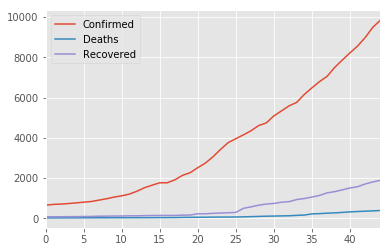

In [10]:
#plotting confirmed cases
df[['Confirmed', 'Deaths', 'Recovered']].plot()

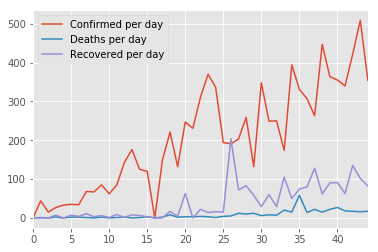

In [11]:
df[['Confirmed per day', 'Deaths per day', 'Recovered per day']].plot()

# Division de los datos para entrenamiento y prueba

In [12]:
df_data = df[['Confirmed per day']]
df_data.head()

,Confirmed per day
0,0.0
1,44.0
2,15.0
3,27.0
4,33.0


Haremos ahora una prediccion por semana, por lo tanto dividiremos los datos de la siguiente manera:

entrenamiento = longitud de la tabla - 7
prueba = ultimos 7 registros

Luego haremos una prediccion con la ultima semana para poder garantizar que nuestro modelo funciona para hacer predicciones precisas.

In [13]:
#iremos por semanas para predicciones
num_time_steps = 7

In [14]:
df_train = df_data.head(len(df_data)-num_time_steps)
df_test = df_data.tail(num_time_steps)

In [15]:
df_test

,Confirmed per day
38,447.0
39,364.0
40,355.0
41,340.0
42,421.0
43,509.0
44,354.0


## Normalizacion de los datos

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
train_scaled = scaler.fit_transform(df_train)

In [19]:
test_scaled = scaler.fit(df_test)

## Funciones para generar lotes de informacion 

In [20]:
def next_batch(training_data,batch_size,steps):
    
    # Generamos un punto aleatorio para iniciar con el lote de datos
    rand_start = np.random.randint(0,len(training_data)-steps) 

    #Creamos los datos para la serie de tiempo en los lotes (tiempo) => (tiempo + 1)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Creamos el modelo de la RNN

In [21]:
import tensorflow as tf

In [22]:
#Creacion de constantes

num_inputs = 1

#numero de neuronas
num_neurons = 100

#salida
num_outputs = 1

#tasa de aprendizaje 
learning_rate = 0.02

#iteraciones para entrenamiento
num_training_iter = 5000

#lotes
num_batch_size = 1

In [23]:
#Creacion de placeholders
X = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_inputs])
Y = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_outputs])

In [24]:
#Creacion de la celda RNN
cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu), 
    output_size=num_outputs)

In [25]:
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

## Funcion de perdida y Optimizador

In [26]:
loss = tf.reduce_mean(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [27]:
#inicializar variables
init = tf.global_variables_initializer()

In [28]:
#instancia para guardar
saver = tf.train.Saver()

In [29]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(num_training_iter):
        X_batch, y_batch = next_batch(train_scaled, num_batch_size, num_time_steps)
        sess.run(train, feed_dict={X:X_batch, Y: y_batch})
    
        #print results every 50 iterations
        if(i%100 == 0):
            mse = loss.eval(feed_dict={X:X_batch, Y: y_batch})
            print(i, "\tMSE: ", mse)
        
    saver.save(sess, '.\covid_time_series')    

0 	MSE:  0.19655077
100 	MSE:  0.040740196
200 	MSE:  0.01668202
300 	MSE:  0.028736448
400 	MSE:  0.034771826
500 	MSE:  0.041478653
600 	MSE:  0.036599666
700 	MSE:  0.07959189
800 	MSE:  0.06993179
900 	MSE:  0.034919817
1000 	MSE:  0.024415776
1100 	MSE:  0.06345533
1200 	MSE:  0.039459962
1300 	MSE:  0.0019141665
1400 	MSE:  0.003396641
1500 	MSE:  0.03661215
1600 	MSE:  0.002491387
1700 	MSE:  0.028152524
1800 	MSE:  0.0026723456
1900 	MSE:  0.009906226
2000 	MSE:  0.021355016
2100 	MSE:  0.032773938
2200 	MSE:  0.045057144
2300 	MSE:  0.028232485
2400 	MSE:  0.029998919
2500 	MSE:  0.03191952
2600 	MSE:  0.029560339
2700 	MSE:  0.004202777
2800 	MSE:  0.0024969853
2900 	MSE:  0.019852221
3000 	MSE:  0.00113077
3100 	MSE:  0.008189837
3200 	MSE:  0.014481412
3300 	MSE:  0.015219731
3400 	MSE:  0.0117091965
3500 	MSE:  0.013068299
3600 	MSE:  0.023326367
3700 	MSE:  0.013702773
3800 	MSE:  0.011061604
3900 	MSE:  0.010305794
4000 	MSE:  0.014969115
4100 	MSE:  0.003568962
4200 	MS

## Haciendo predicciones

In [30]:
df_test

,Confirmed per day
38,447.0
39,364.0
40,355.0
41,340.0
42,421.0
43,509.0
44,354.0


In [31]:
with tf.Session() as sess:
    
    #cargamos el modelo
    saver.restore(sess, '.\covid_time_series')
    
    #tomaremos los ultimos 7 datos para hacer prediccion en los siguientes 7
    train_seed = list(train_scaled[-num_time_steps:])
    
    for i in range(num_time_steps):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from .\covid_time_series


In [32]:
train_seed

[array([0.6319797]),
 array([0.63451777]),
 array([0.44162437]),
 array([1.]),
 array([0.84010152]),
 array([0.77918782]),
 array([0.66751269]),
 0.84261364,
 0.60501665,
 0.66533846,
 0.42988992,
 1.0335205,
 0.7866036,
 0.60200673]

In [33]:
#tomamos los ultimos 10 datos
results = scaler.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(num_time_steps,1))
results

array([[482.40167],
       [442.2478 ],
       [452.44217],
       [412.6514 ],
       [514.665  ],
       [472.936  ],
       [441.73914]], dtype=float32)

In [34]:
df_test['Predicted'] = results

D:\anaconda3\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
df_test

,Confirmed per day,Predicted
38,447.0,482.401672
39,364.0,442.247803
40,355.0,452.442169
41,340.0,412.651398
42,421.0,514.664978
43,509.0,472.936005
44,354.0,441.739136


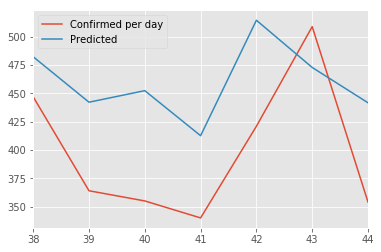

In [36]:
#grafica de los datos para prueba y las predicciones realizadas por el modelo. Esto es para los ultimos 7 dias de datos extraidos.
df_test.plot()

## Haciendo predicciones reales

In [37]:
df_data.tail(num_time_steps)

,Confirmed per day
38,447.0
39,364.0
40,355.0
41,340.0
42,421.0
43,509.0
44,354.0


In [38]:
df_scaled_test = scaler.fit_transform(df_data.tail(num_time_steps))
df_scaled_test

array([[0.63313609],
       [0.14201183],
       [0.0887574 ],
       [0.        ],
       [0.47928994],
       [1.        ],
       [0.08284024]])

In [39]:
with tf.Session() as sess:
    
    saver.restore(sess, '.\covid_time_series')
    
    #tomaremos los ultimos 7 datos para hacer prediccion en los siguientes 7
    test_seed = list(df_scaled_test[-num_time_steps:])
    
    for i in range(num_time_steps):
        X_batch = np.array(test_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        

INFO:tensorflow:Restoring parameters from .\covid_time_series


In [40]:
test_seed[-1].item()

0.08284023668639051

In [41]:
#agregamos el ultimo punto de los datos reales para poder visualizar correctamente las predicciones
y_pred=np.append(test_seed[-1].item(), y_pred)
y_pred

array([0.08284024, 0.53869003, 1.15493464, 0.06580661, 0.35671118,
       0.53345984, 0.79839534, 1.61019528])

In [42]:
final_results = pd.DataFrame(data=scaler.inverse_transform(y_pred.reshape(-1,1)), columns=['predicciones'], index=np.arange(len(df_data)-1, len(df_data)+num_time_steps))
final_results

,predicciones
44,354.000000
45,431.038615
46,535.183955
47,351.121317
48,400.284189
49,430.154713
50,474.928812
51,612.123002


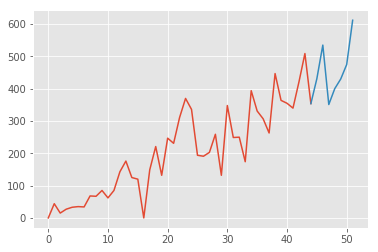

In [43]:
#grafica de predicciones futuras 
plt.plot(df_data, label="Datos reales")
plt.plot(final_results, label="Predicciones")

In [44]:
import datetime

## Predicciones para la semana entrante

In [67]:
final_results['fecha'] = pd.date_range(start=end, end=datetime.datetime.strptime(end, '%Y-%m-%d') + datetime.timedelta(num_time_steps))
final_results

,predicciones,fecha
44,354.000000,2020-06-14
45,431.038615,2020-06-15
46,535.183955,2020-06-16
47,351.121317,2020-06-17
48,400.284189,2020-06-18
49,430.154713,2020-06-19
50,474.928812,2020-06-20
51,612.123002,2020-06-21
